In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.svm import SVC, LinearSVC # LinearSVC is faster with large datasets

In [2]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_decision_svm(X_train, y_train, clf):
    fig, ax = plt.subplots()
    X0, X1 = X_train[:, 0], X_train[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c = y_train, cmap = plt.cm.coolwarm, s = 20, edgecolors = 'k')
    plt.show()


In [3]:
def L2_dist(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2)))

In [4]:

class incremental_svm():

    def __init__(self, threshold = None):
        
        self.bias = None
        self.weights = None
        self.X_retained = None
        self.y_retained = None
        
        self.pos_centroid = None
        self.neg_centroid = None
        self.threshold = threshold
        self.support_vec_ids = None
        
        self.clf = None # for plotting

        # metrics to log 
        self.min_dist_DB = 1e10
        self.min_pairwise_dist = 1e10


    def fit(self, X, y):
        """
        inputs  : X_init (numpy array)
                  y_init (numpy vector)
        outputs : None 
        """
        self.clf = SVC(kernel = 'linear')
        self.clf.fit(X, y)
        self.bias = self.clf.intercept_ 
        self.weights = self.clf.coef_
        self.support_vec_ids = set(self.clf.support_)
        self.update_candidates(X, y)

    ### TODO: IMPLEMENT PARTIAL FIT (OPTIONAL)

    def distance_DB(self, x, y):
        """
        inputs  : x (numpy vector)
                  y (int: 1 or -1)
        outputs : distance to hyperplane
        """
        assert (y == -1) or (y == 1) # should not pass 0
        fx = np.dot(self.weights, x) + self.bias
        return y * (fx) / np.linalg.norm(self.weights)


    def update_candidates(self, X, y):
        """
        inputs  : X (numpy array)
                  y (numpy vector)
        outputs : None
        """
        # centroids
        pos_X = X[np.where(y == 1)]
        neg_X = X[np.where(y == 0)]
        self.pos_centroid = np.mean(pos_X, axis = 0)
        self.neg_centroid = np.mean(neg_X, axis = 0)

        # distance to closest svec
        R_pos = R_neg = 1e10
        for i in self.support_vec_ids: 
            
            pos_dist = L2_dist(self.pos_centroid, X[i])
            neg_dist = L2_dist(self.neg_centroid, X[i])

            R_pos = min(pos_dist, R_pos)
            R_neg = min(neg_dist, R_neg)

        # centoids to hyperplane distances
        R0_pos = self.distance_DB(self.pos_centroid, 1)
        R0_neg = self.distance_DB(self.neg_centroid, -1)

        # logging min_pairwise_dist (only searching among svecs)
        svec_ids_array = np.array(list(self.support_vec_ids))
        X_svecs_pos = X[svec_ids_array, :][y[svec_ids_array] == 1]
        X_svecs_neg = X[svec_ids_array, :][y[svec_ids_array] == 0]

        self.min_pairwise_dist = 1e5
        for x_pos in X_svecs_pos:
            for x_neg in X_svecs_neg:
                self.min_pairwise_dist = min(self.min_pairwise_dist, L2_dist(x_pos, x_neg))

        # selecting CSVs
        self.X_retained = []
        self.y_retained = []
        for i in range(X.shape[0]):

            if i in self.support_vec_ids: 
                self.X_retained.append(X[i])
                self.y_retained.append(y[i])

                # logging min_dist TO TRUTH (only need searching among support vecs)
                # self.min_dist_DB = min(self.min_dist_DB, CALL TRUE DB DISTANCE FUNCTION)

            else:
                if y[i] == 1:
                    d = L2_dist(X[i], self.pos_centroid)
                else:
                    d = L2_dist(X[i], self.neg_centroid)                

                if not isinstance(self.threshold, float):
                    if y[i] == 1:
                        if (d >= R_pos) and (self.distance_DB(X[i], 1) <= R0_pos):
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
                    else:
                        if (d >= R_neg) and (self.distance_DB(X[i], -1) <= R0_neg):
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])

                else:                     
                    
                    L = 1 / np.linalg.norm(self.weights) # 1/2 margin distance
                    
                    if y[i] == 1:
                        t = d / (d + R_pos) + L / (L + self.distance_DB(X[i], 1)) - 1
                        if -self.threshold < t < self.threshold:
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
                    else:
                        t = d / (d + R_neg) + L / (L + self.distance_DB(X[i], -1)) - 1
                        if -self.threshold < t < self.threshold:
                            self.X_retained.append(X[i])
                            self.y_retained.append(y[i])
      
        self.X_retained = np.array(self.X_retained)
        self.y_retained = np.array(self.y_retained)

    def update(self, X, y, tol = 1e-3):

        if X.ndim == 1:
            X = np.expand_dims(X, axis = 0)

        X_violations = []
        y_violations = []
        for i in range(X.shape[0]):
            if y[i] == 1:
                if (self.distance_DB(X[i], 1) < 1 - tol):
                    X_violations.append(X[i])
                    y_violations.append(y[i])

            else:
                if (self.distance_DB(X[i], -1) < 1 - tol):
                    X_violations.append(X[i])
                    y_violations.append(y[i])

        if X_violations == []:
            return 

        else:

            # TODO: CHECK FOR FIT VS PARTIAL FIT  (OPTIONAL) 

            self.X_retained = np.vstack((self.X_retained, X_violations))
            self.y_retained = np.append(self.y_retained, y_violations)

            self.fit(self.X_retained, self.y_retained)



workflow
fit init - update candidates -> APPEND violations - fit updated data - update candidates

svec workflow
fit init (svec correct) - update candidates (svecs wrong) - append violations (svecs same wrong) - fit updated (svecs correct) - update candidates (svecs wrong)

## Testing

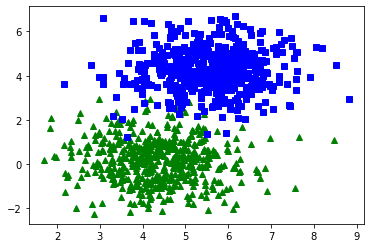

In [5]:
X, y = datasets.make_blobs(n_samples = 1000, centers = 2, n_features = 2, center_box = (0, 10), random_state = 2)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [6]:
X_init, y_init = X[:500, :], y[:500]
X_u1, y_u1 = X[500:700, :], y[500: 700]
X_u2, y_u2 = X[700:, :], y[700:]

In [7]:
# testing for weird patterns of updates
# X_init, y_init = X[X[:, 0] > 5.5, :], y[X[:, 0] > 5.5]
# X_u1, y_u1 = X[(X[:, 0] < 5.5) & (X[:, 0] > 4), :], y[(X[:, 0] < 5.5) & (X[:, 0] > 4)]
# X_u2, y_u2 = X[X[:, 0] < 4, :], y[X[:, 0] < 4]

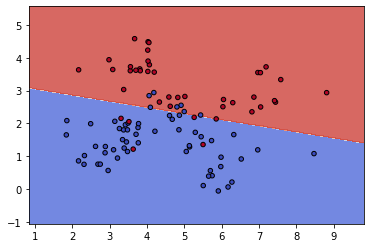

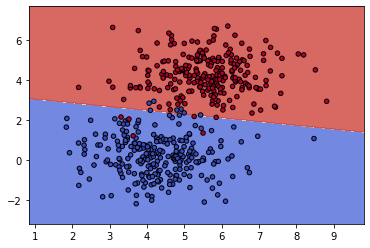

In [8]:
proxy = incremental_svm(1)
proxy.fit(X_init, y_init)

X_a, y_a = X_init, y_init
attacker = SVC(kernel = 'linear')
attacker.fit(X_a, y_a)

plot_decision_svm(proxy.X_retained, proxy.y_retained, proxy.clf)
plot_decision_svm(X_a, y_a, attacker)

In [9]:
print(proxy.weights, proxy.bias)
print(attacker.coef_, attacker.intercept_)
print(proxy.X_retained.shape[0], proxy.min_dist_DB, proxy.min_pairwise_dist)

[[0.32672409 1.74693021]] [-5.65451823]
[[0.32672409 1.74693021]] [-5.65451823]
100 10000000000.0 0.04801413888308045


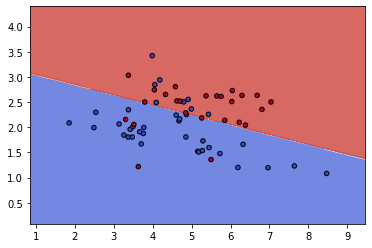

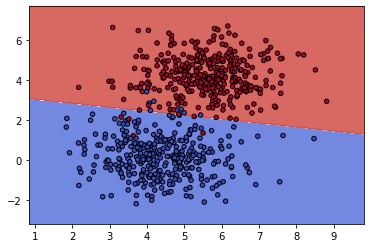

In [10]:
proxy.update(X_u1, y_u1)

X_a = np.vstack((X_a, X_u1))
y_a = np.append(y_a, y_u1)
attacker.fit(X_a, y_a)

plot_decision_svm(proxy.X_retained, proxy.y_retained, proxy.clf)
plot_decision_svm(X_a, y_a, attacker)

In [11]:
print(proxy.weights, proxy.bias)
print(attacker.coef_, attacker.intercept_)
print(proxy.X_retained.shape[0], proxy.min_dist_DB, proxy.min_pairwise_dist)

[[0.39663618 2.00802945]] [-6.50056106]
[[0.39663618 2.00802945]] [-6.50056106]
63 10000000000.0 0.04067042943213478


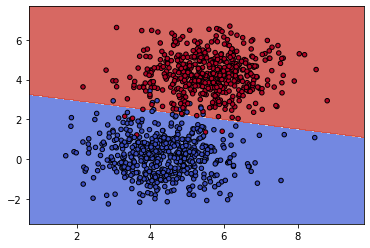

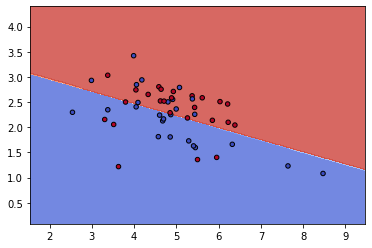

In [12]:
proxy.update(X_u2, y_u2)

X_a = np.vstack((X_a, X_u2))
y_a = np.append(y_a, y_u2)
attacker.fit(X_a, y_a)

plot_decision_svm(X_a, y_a, attacker)
plot_decision_svm(proxy.X_retained, proxy.y_retained, proxy.clf)

In [13]:
print(proxy.weights, proxy.bias)
print(attacker.coef_, attacker.intercept_)
print(proxy.X_retained.shape[0], proxy.min_dist_DB, proxy.min_pairwise_dist)

[[0.45781557 1.8970409 ]] [-6.51921911]
[[0.45793316 1.92589501]] [-6.58352058]
51 10000000000.0 0.03984523023989233


In [14]:
from pympler import asizeof
print(str(asizeof.asizeof(proxy) / 1e6) + ' mb')

0.01268 mb
